# Feature Importance

## Introduction

**Learning Objectives**

- How to load in a previously trained model.
- What is the Captum xAI Python package.
- What is feature ablation and how does it work?
- How to extend feature importance with LIME.

This lesson will focus on the importance of sub-features for the efficacy of a machine learning model. **Feature Importance** is one of the simplest and most interpretable methods for explaining predictions made by a machine learning model. It works by shuffling or removing the values of each feature in the input data and measuring the impact on the model's predictions. The higher the impact, the more important the feature is for making predictions.

To do this, we will be using a Python package called [Captum](https://captum.ai/docs/introduction), which is a model interpretability library for PyTorch. It is an easy to use tool for understanding the decisions made by a neural network. It is also a great tool for debugging and improving models.

The main focus of the lesson will be with images, however the final section will cover tabular data to demonstrate the generalisability of the methods.

NOTE BOX

Captum also works with text data, pre-trained models, regression tasks, and large language models, in addition to the images and tabular data covered in this lesson.

## Setup

In this activity we will utilise the model we trained in the previous lesson on **CNNs**, to explore and interpret the predictions using the **occlusion** method from **Captum**.

To replicate the model we made previously we will need to re-initialise the model architecture, load the previously trained weights (parameters), and append it to our model.

First we will import the suite of packages we used in the previous lesson.

In [2]:
# Import the modules required:
import torch # this is the PyTorch module
import torch.nn as nn # this is the neural network module

import warnings
warnings.filterwarnings("ignore") # this is to ignore warnings

# Import the MNIST dataset
from torchvision import datasets, transforms
import torch.utils.data as data

# Import the matplotlib module
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Import the numpy module
import numpy as np

# import medmnist, the medical image dataset
import medmnist

# fix the numpy and torch seeds for reproducibility:
SEED = 999
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

And we will also download and store the data from the `pathmnist` dataset, which are colons pathology samples.

In [3]:
data_flag = 'pathmnist'

info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

print(f"The learning task is {task}")
print(f"The number of channels is {n_channels}")
print(f"The number of classes is {n_classes}")

The learning task is multi-class
The number of channels is 3
The number of classes is 9


In [ ]:
download = True
BATCH_SIZE = 128

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]) # normalise the data with standard values
])

train_loader = torch.utils.data.DataLoader(
    DataClass(split='train', 
                transform=data_transform, 
                download=download, 
                root='data'),
    batch_size=BATCH_SIZE, shuffle=True)

# load the data
test_loader = torch.utils.data.DataLoader(
    DataClass(split='test', 
                transform=data_transform, 
                download=download, 
                root='data'),
    batch_size=2*BATCH_SIZE)

To recreate our model, we simply execute the code containing the same neural network architecture as before.

In [8]:
# A CNN_Pathology model class but with dropout layers to avoid overfitting:

class CNN_Pathology(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.layer1 = nn.Sequential(
            # Input image: 28x28, Output image: 28 - 3 + 1 = 26x26
            nn.Conv2d(in_channels, 16, kernel_size=3), 
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            # Input image: 26x26, Output image: (26 - 3 + 1) / 2 = 12x12
            nn.Conv2d(16, 16, kernel_size=3), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            # Input image: 12x12, Output image: 12 - 3 + 1 = 10x10
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            # Input image: 10x10, Output image: 10 - 3 + 1 = 8x8
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            # Input image: 8x8, Output image: (8 - 3 + 1 + 2(1)) / 2 = 4x4
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128), # 64 feature maps x spatial dimensions (4x4)
            nn.ReLU(),
            # a dropout layer is added here to avoid overfitting
            nn.Dropout(p=0.6),
            nn.Linear(128, 128),
            nn.ReLU(),
            # a dropout layer is added here to avoid overfitting
            nn.Dropout(p=0.6),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

### Loading a saved model

At the end of the previous lesson we saved the parameters of the best performing model to a `.pth` file. If we want to use this model again, to predict on new data or for further training, it can be loaded back into the environment by updating the **state** of a newly initialised neural net class.

REMEMBER BOX

Saved parameters can only be loaded into a neural net class that has the same architecture as the previous model. Do not lose the code that defined the model the first time!

In [9]:
# Define the device
if torch.cuda.is_available():
    # if there are multiple GPUs, choose the first one
    device = torch.device("cuda") # Defines the device you want to have data moved to
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print(f"Using: {device} (Cuda)")

elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using: {device} (Apple Silicon)")

else:
    print("No GPU detected! Falling back to CPU")
    # If the GPU is not available, use the CPU
    device = torch.device("cpu")

# then define the model (architecture above) and move it to the device:
model = CNN_Pathology(in_channels=n_channels, num_classes=n_classes)

# load the trained model that we saved in the last lesson, instead of having to train it again:
model.load_state_dict(torch.load('./data/best_model.pth', weights_only=True))
model = model.to(device)

Using: mps (Apple Silicon)


Now everything is loaded in, we can view our model predictions to remind us of what we are working with:

In [10]:
# load all the test set images and labels into memory:
test_images = []
test_labels = []
for images, labels in test_loader:
    test_images.append(images)
    test_labels.append(labels)
test_images = torch.cat(test_images, dim=0)
test_labels = torch.cat(test_labels, dim=0)

In [11]:
real_labels = {
            0: "adipose",
            1: "background",
            2: "debris",
            3: "lymphocytes",
            4: "mucus",
            5: "smooth muscle",
            6: "normal colon mucosa",
            7: "cancer-associated stroma",
            8: "crc adenocarcinoma epithelium"
        }

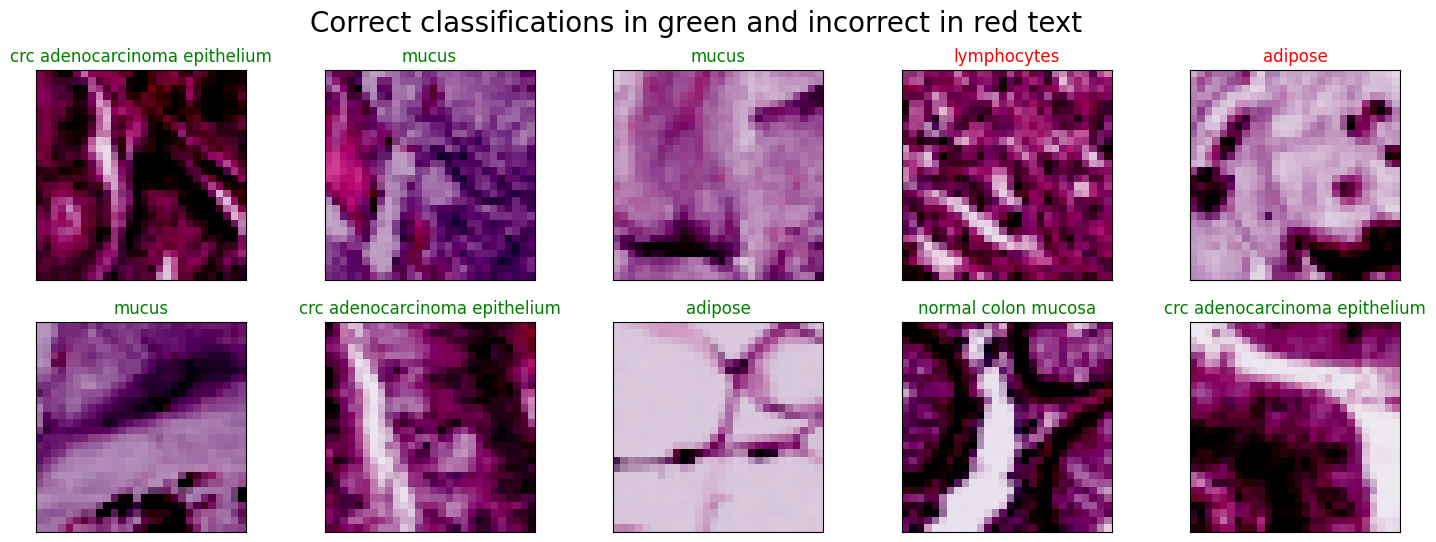

In [12]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.numpy()

# move model inputs to cuda, if GPU available
images = torch.from_numpy(images)
images = images.to(device)
labels = labels.to(device)

# get sample outputs
model.eval() # set model to evaluation mode
output = model(images)

# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# prep images for display
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(18, 6))

for idx in np.arange(10):
    # get the real labels of the pathology images
    # and use these real labels to annotate the images
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.clip(np.transpose(images[idx], (1, 2, 0)), 0, 1))
    ax.set_title(f"{real_labels[int(preds[idx].cpu().numpy())]}", color=("green" if preds[idx]==labels[idx] else "red"))

# add super title:
fig.suptitle('Correct classifications in green and incorrect in red text', fontsize=20)
plt.show()

## Occlusion introduction

To start off, we can use an explainability method called **Occlusion**. This is a visualisation technique that can be used to understand the importance of different regions of an image in the model's prediction.

It does this by occluding (hiding) different regions of the image and observing the effect on the model's prediction. If the model's prediction changes substantially when a region is occluded, then that region is important for the prediction. If the model's prediction does not change, then that region is not important.

![Occlusion Diagram](./images/occlusion.png)

For this demonstration, let us only consider the samples that were classified **correctly** by the model.

In [13]:
correct_indices = []
for i in range(len(labels)):
    if preds[i] == labels[i]:
        correct_indices.append(i)

# shuffle the correct indices list:
np.random.shuffle(correct_indices)

From the **Captum** package we import the Occlusion class. The Occlusion class will determine the importance of each **pixel** in the model's prediction.

In [14]:
from captum.attr import Occlusion

## Implementing Occlusion

After initialising the [**Occlusion** class](https://captum.ai/api/occlusion.html) with our model, we need to define the window *shape* and its *stride*. This is very similar to the kernel defined for the convolutional layer, as in we choose the height and width of the window and how much it should move along the image (*stride*).

The difference is we also need to declare the number of channels, as it needs to block all of the pixels in the Z-axis (channel).

In [15]:
# define the occlusion interpreter
occlusion = Occlusion(model)

# define the sliding window size for the occlusion interpreter
sliding_window_shapes = (3, 2, 2) # (channels, height, width)

# define the stride for the occlusion interpreter
strides = (3, 1, 1)               # (channel_stride, height_stride, width_stride)

In [16]:
# Load in a single image from the correctly predicted images for demonstration

# select an image from correct_indices
IMAGE_INDEX = 11

# Download and uncomment the below to view other random images
# IMAGE_INDEX = np.random.choice(correct_indices)

# Pick image and its label
original_image = test_images[IMAGE_INDEX].unsqueeze(0) # get image
original_label = test_labels[IMAGE_INDEX] # get label 

# move the image and label to the device
original_image = original_image.to(device)
original_label = original_label.to(device)

We can now use the occlusion interpreter to infer the importance of each pixel in the image for the model’s prediction. First, we get the prediction for our image which we give to the occulsion class along with the window and stride.

In [ ]:
# get the prediction of the model for the image
model.eval() # set model to evaluation mode

output = model(original_image)
_, pred_class = torch.max(output, 1) # convert output probabilities to predicted class

# run the occlusion interpreter on the image
attributions_occ = occlusion.attribute(original_image,
                                        strides=strides,
                                        target=pred_class,
                                        sliding_window_shapes=sliding_window_shapes,
                                        )


# pred class in text:
pred_class_text = real_labels[pred_class.cpu().numpy()[0]]
# real label in text:
real_label_text = real_labels[original_label.cpu().numpy()[0]]

### Visualisation

To best understand which pixels are important we can visualise the feature importance as a heatmap. The numbers given from the `Occlusion` class can be roughly binned into 3 categories:

- **Positive values** (green): Regions that **support** the predicted class. When these areas are occluded (hidden), the model's confidence in the prediction decreases.
- **Negative values** (red): Regions that **contradict** the predicted class. When these areas are occluded, the model's confidence actually increases (meaning these regions were working against the prediction).
- **Around zero** (white): Regions that have little to no impact on the prediction. Occluding them does not significantly change the model's output.

First we need to augment our data so that it can be given to matplotlib:

In [18]:
# detach the data from the PyTorch tensor
attributions_data = attributions_occ.squeeze(0).detach().cpu().numpy() # .squeeze(0) removes the first singular dimension 
attributions_data = attributions_data[0] # We only need 1 channel

plot_image = np.clip(np.transpose(original_image.cpu().numpy()[0], (1, 2, 0)), 0, 1)

TIP BOX

The augmentation of the images for plotting may be a bit confusing to beginners, so we will break it down step by step:

```
plot_image = np.clip(np.transpose(original_image.cpu().numpy()[0], (1, 2, 0)), 0, 1)

np.clip(..., 0, 1) # As we have normalised the images, the pixel values will be outside [0, 1]. We therefore rescale to between 0 and 1

image.cpu().numpy()[0] # PyTorch → NumPy and remove an unnecessary dimension

# For matplotlib we need the channels to be last, not first, so we transpose the image
np.transpose(..., (1, 2, 0)) # (C,H,W) → (H,W,C) for matplotlib
```

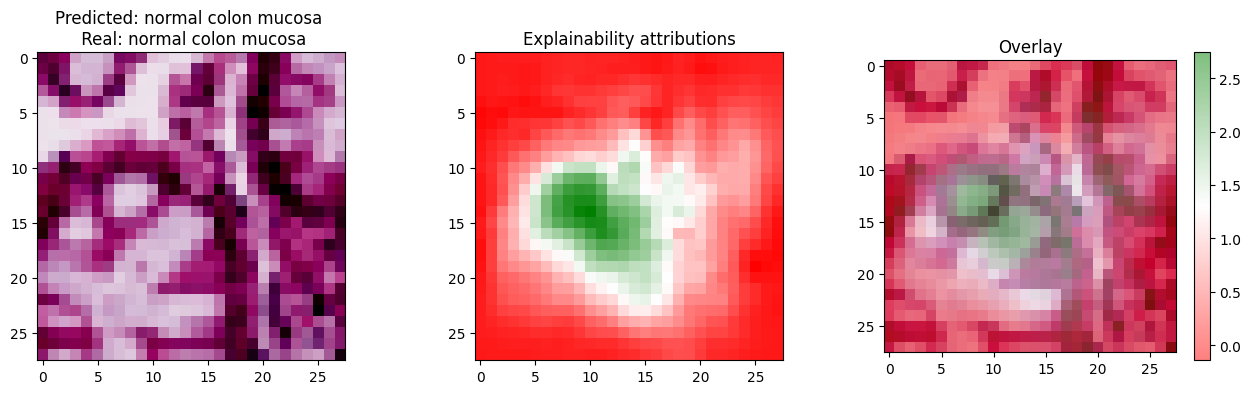

In [19]:
# Create our own red, white, green colour map for plotting
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)

# plot the image and the attributions in a side by side manner as a subplot
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(plot_image)
ax[0].set_title(f"Predicted: {pred_class_text} \n Real: {real_label_text}")

ax[1].imshow(attributions_data, cmap=cmap)
ax[1].set_title("Explainability attributions")

# make an overlay of the image and the attributions
ax[2].imshow(plot_image)
im = ax[2].imshow(attributions_data, cmap=cmap, alpha=0.5)
ax[2].set_title("Overlay")

# put a colorbar on the side
fig.colorbar(im, ax=ax[2])

plt.show()

### Plotting issues

Plotting it ourselves can cause issues when we wish to visually compare multiple images. This is because the colourbar is automatically adjusted to the range of values. Here, pixels that are `0` are coloured red, which would signal at a glance that they were negatively affecting the prediction, whereas we know this should mean it has little impact either for or against.

To prevent this, we could rescale the colour bar. Alternatively, we can use [Captum's](https://captum.ai/api/utilities.html#visualization) built-in visualisation tools, which handle this automatically given their knowledge of the numerical limits of the output. This toolkit is built on top of *Matplotlib*.

In [20]:
# THe Captum visualisation module
from captum.attr import visualization as viz

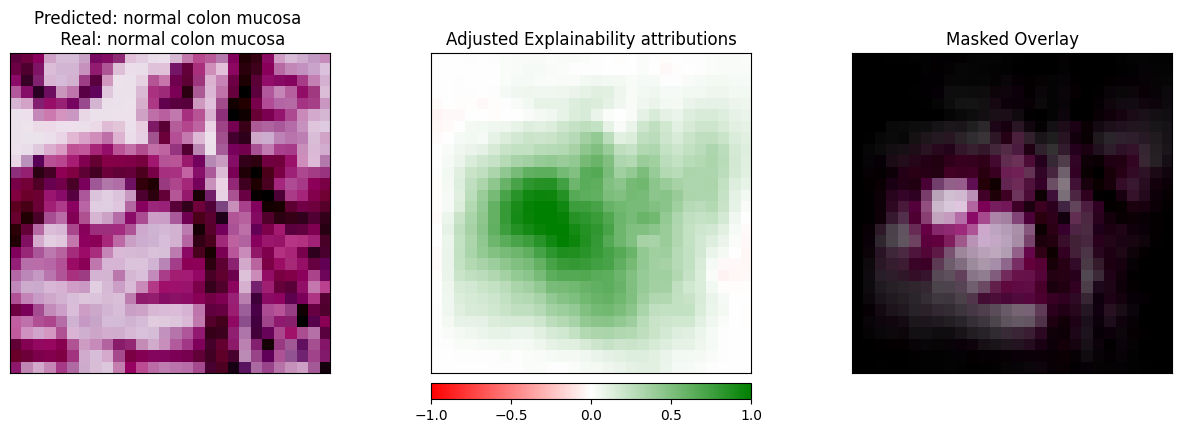

In [21]:
# The occlusion data must be transposed to work the visualisation module
attributions_data = np.transpose(attributions_occ.squeeze(0).cpu().detach().numpy(), (1,2,0))

# Extract the figure and axes from the visualisation
fig, ax = viz.visualize_image_attr_multiple(attributions_data, # the same numbers
                                      plot_image, # the same image
                                      ['original_image', 'heat_map', 'masked_image'], # image type
                                      ["all", "all", "positive"], # values to show
                                      show_colorbar=True,
                                      use_pyplot=False, # allows us to customise the figure
                                      fig_size=(14, 4));


fig.tight_layout()

ax[0].set_title(f"Predicted: {pred_class_text} \n Real: {real_label_text}")
ax[1].set_title("Adjusted Explainability attributions")
ax[2].set_title("Masked Overlay")

fig

Using the **Captum** visualisation tool we gain a better understanding of the true influencing features in the image. Here we can see the central to bottom left region is most predictive of the class, with the remainder largely unaffected. It is an important reminder to always pay attention to the scale of a colourmap when cross-comparing different visualisations.

## Occluding segments

### Moving Beyond Pixel-Level Heatmaps

Heatmaps are useful for showing which parts of an image influence the model's decision, but they have limitations. They highlight important regions without explaining what the AI has actually learnt about those areas. To gain deeper insights, we should move beyond individual pixels and analyse meaningful regions of the image.

Ideally, we would analyse images at the level of distinct objects or structures. In medical imaging, expert pathologists sometimes provide pixel-level annotations that identify every structure in an image — this is called supervised segmentation. However, such detailed annotations are expensive and time-consuming to create.

When expert annotations are not available, unsupervised segmentation can be used to automatically divide the image into meaningful regions. This allows us to analyse how the AI interprets different structures without requiring pre-labelled data.

### Our Approach: Unsupervised Segmentation

The following two-step process is used to segment the pathology images:

**Step 1 — Binarisation:** We separate the tissue (foreground) from the background using Otsu's thresholding method. This technique automatically finds the optimal threshold by assuming the image contains two classes of pixels and minimising the variance within each class.

**Step 2 — Connected Component Analysis:** Next, we identify distinct regions in the binarised image. This method groups together neighbouring pixels that belong to the same structure, giving each region a unique label. These labelled regions become our units of analysis for the explainability method.

In [22]:
import cv2
from skimage.filters import threshold_otsu

FACT BOX

[cv2](https://opencv.org/) or OpenCV is a powerful and open source computer vision library that can be used for image and video processing.

### Step 1

First the image is converted to greyscale. Next, [threshold_otsu](https://scikit-image.org/docs/0.23.x/auto_examples/segmentation/plot_thresholding.html) provides a *threshold* value, which it calculates best separates the foreground from the background.

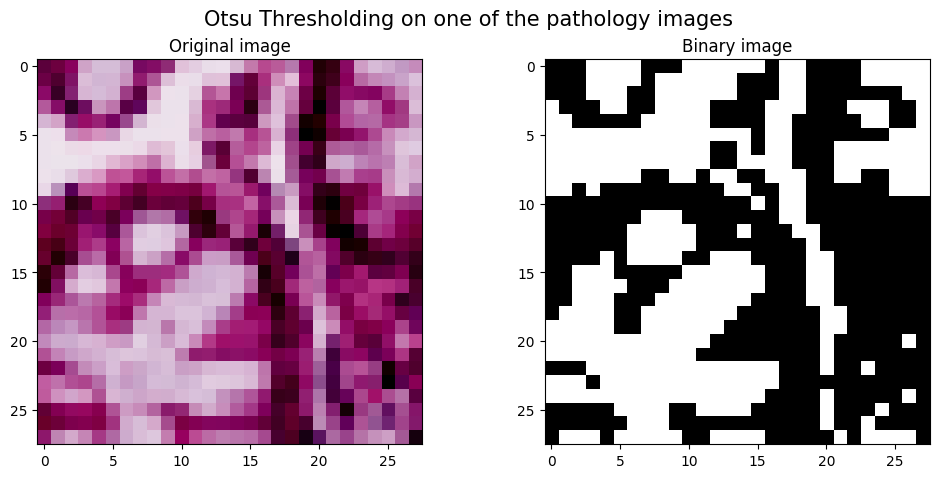

In [23]:
# Use Otsu Thresholding 
# convert the image to grayscale
grey = cv2.cvtColor(plot_image, cv2.COLOR_BGR2GRAY)

# apply Otsu's thresholding method to binarise the image
thresh = threshold_otsu(grey)
binary = grey > thresh # where image is greater than threshold, set to true (1)

# Plot the binary image
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(plot_image)
ax[0].set_title("Original image")

ax[1].imshow(binary, cmap="gray")
ax[1].set_title("Binary image")

fig.suptitle('Otsu Thresholding on one of the pathology images', fontsize=15)

plt.show()

### Step 2

The [Connected Components](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#gaedef8c7340499ca391d459122e51bef5) function computes the number of components in the binary image based on how closely connected pixels are to others of the same intensity. The output is an identical matrix with pixels replaced with numerical labels.

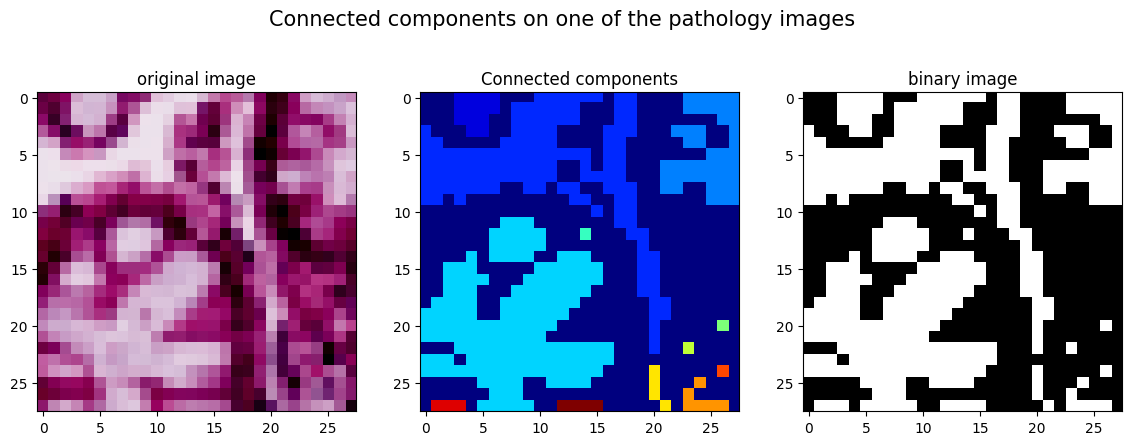

In [24]:
# find the connected components in the image
n_components, labels = cv2.connectedComponents(binary.astype(np.uint8)) # convert to 8-bit image and find labels

# plot the image and the binary image in a side by side manner as a subplot
fig, ax = plt.subplots(1, 3, figsize=(14, 5))


ax[0].imshow(plot_image)
ax[0].set_title("original image")

ax[1].imshow(labels, cmap="jet") # each unique label represents a different segment
ax[1].set_title("Connected components")

ax[2].imshow(binary)
ax[2].imshow(binary, cmap="gray")
ax[2].set_title("binary image")

fig.suptitle('Connected components on one of the pathology images', fontsize=15)
plt.show()

## Results: Segment importance

Now we have the segment, the function [FeatureAblation](https://captum.ai/api/feature_ablation.html) can be used instead of **Occlusion**. This class will occlude each segment at a time, instead of on a per pixel basis. The steps to apply and view the results are the same as for the **Occlusion method**.

In [25]:
from captum.attr import FeatureAblation

In [26]:
# Create the feature ablation interpreter
feature_ablation = FeatureAblation(model)

# Convert labels to a mask format that Captum can use
mask = torch.from_numpy(labels).unsqueeze(0).unsqueeze(0).to(device) # Have labels match dimensions of the image

# Get attributions for each segment
attributions_seg = feature_ablation.attribute(
    original_image, # image as tensor
    target=pred_class,
    feature_mask=mask,
    perturbations_per_eval=1
)

attribution_map = attributions_seg.squeeze(0).cpu().detach().numpy()
attribution_map = np.transpose(attribution_map, (1,2,0))


NOTE BOX

The double `.unsqueeze(0)` is needed to align the shape of the `labels` array with the shape of the image tensor that Captum expects, by adding a new dimension at position 0

`cv2.connectedComponents` returns a 2D array of shape `(height, height)`. However, Captum's `feature_mask` must match the full image tensor dimensions, which are `(batch (1), channels (1), height, height)`.

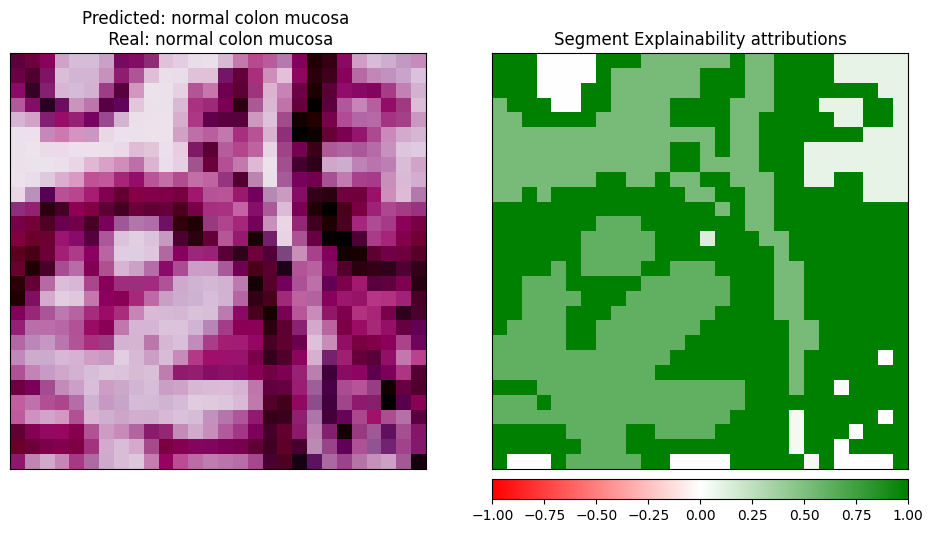

In [27]:
# Extract the figure and axes from the visualisation
fig, ax = viz.visualize_image_attr_multiple(attribution_map,
                                      plot_image, # the same image
                                      ['original_image', 'heat_map'], # image type
                                      ["all", "all"], # values to show
                                      show_colorbar=True,
                                      use_pyplot=False, # allows us to customise the figure
                                      fig_size=(10, 5));


fig.tight_layout()

ax[0].set_title(f"Predicted: {pred_class_text} \n Real: {real_label_text}")
ax[1].set_title("Segment Explainability attributions")

fig

The *three* largest segments all appear to positively help with the prediction of the class. Specifically, the darker tissue segment has a score of **1.0**, indicating without it the model is unable to make a correct prediction.

### Comparing importance methods

Comparing the **per pixel** method with the **segments** approach reveals an encouraging degree of overlap. However, the segment-based method produces a different pattern: because occluding entire segments has a larger effect, the positive importance values tend to spread across the whole image rather than concentrating in a single area. Since our segments come from unsupervised thresholding and we lack expertise in colon histopathology, it is difficult to determine whether we have truly segmented distinct tissue regions. Therefore, we cannot definitively say which importance map provides a better representation.

As with all approaches to understanding a model, having a domain expert is **essential** for extracting meaningful insights from the outcome.

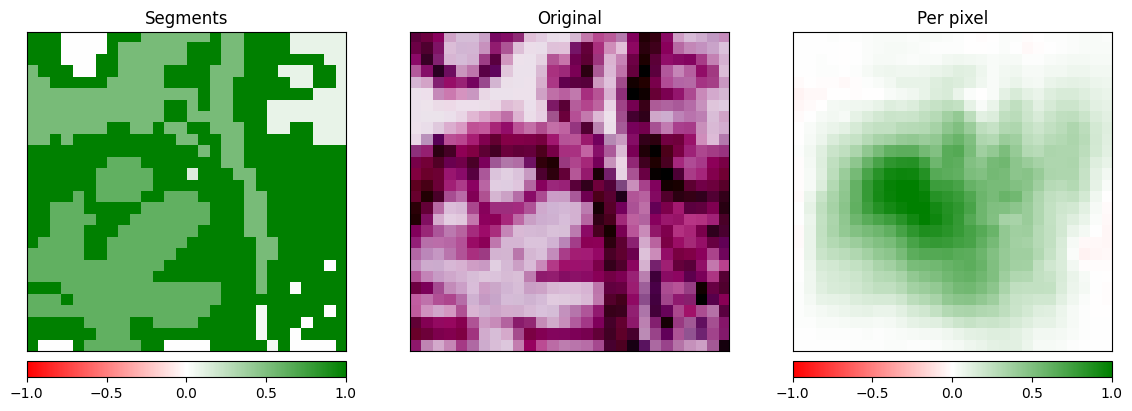

In [28]:
# Create figure with 5 subplots
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

methods = ['heat_map', 'original_image', 'heat_map']
signs = ["all", "all", "all"]

for i, (method, sign) in enumerate(zip(methods, signs)):

    if i == 2: # For final image use the pixel data, not segments

        viz.visualize_image_attr(
            attributions_data,
            plot_image,
            method=method,
            sign=sign,
            plt_fig_axis=(fig, ax[i]),
            use_pyplot=False,
            show_colorbar=True
        )

    else:

        viz.visualize_image_attr(
            attribution_map,
            plot_image,
            method=method,
            sign=sign,
            plt_fig_axis=(fig, ax[i]),
            use_pyplot=False,
            show_colorbar=True
        )

ax[0].set_title("Segments")
ax[1].set_title("Original")
ax[2].set_title("Per pixel")
plt.show()

TIP BOX

To combine plots into custom subplots, use the `viz.visualize_image_attr` function (which plots one Captum plot at a time) with a `for` loop. Non-Captum plots can also be added to the same figure this way.

## LIME

LIME, which stands for **Local Interpretable Model-Agnostic Explanations**, can be viewed as an extension of the feature segmentation with ablation described previously.

LIME is a versatile tool that works with any machine learning model. Similar to the occlusion method, it operates by modifying the original image — such as turning pixels or features on and off randomly. These altered images are then used to train a simple, more interpretable model, such as a linear model, which aims to mimic the original model's decisions. The insights gained from the linear model help explain what the AI is focusing on in the images.

In [29]:
from captum.attr import Lime

In [30]:
# define the lime interpreter
lime = Lime(model)

# get the model’s prediction
pred = model(original_image)
pred_class = pred.argmax(dim=1) # get the class

attributions_lime = lime.attribute(original_image,
                                    target=pred_class,
                                    feature_mask=mask,
                                    )

In [31]:
# Prepare the data for visualisation
lime_data = np.transpose(attributions_lime.squeeze().cpu().detach().numpy(), (1, 2, 0))

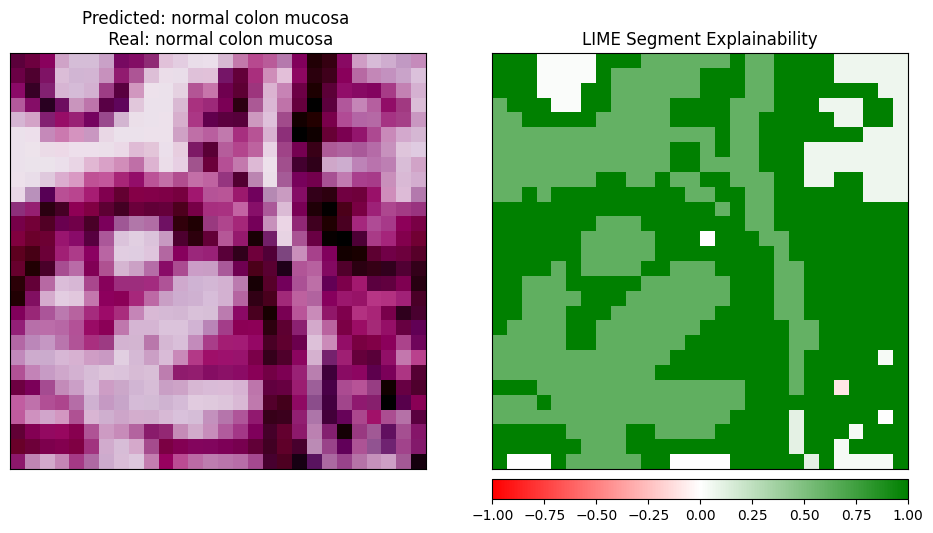

In [32]:
# Extract the figure and axes from the visualisation
fig, ax = viz.visualize_image_attr_multiple(lime_data,
                                      plot_image, # the same image
                                      ['original_image', 'heat_map'], # image type
                                      ["all", "all"], # values to show
                                      show_colorbar=True,
                                      use_pyplot=False, # allows us to customise the figure
                                      fig_size=(10, 5));


fig.tight_layout()

ax[0].set_title(f"Predicted: {pred_class_text} \n Real: {real_label_text}")
ax[1].set_title("LIME Segment Explainability")

fig

The result looks very similar to the previous example, with the darker tissue segments being the most predictive of normal colon mucosa. 

## Results: Comparing LIME

To get a better understanding of any predictive differences, let us plot them all on the same figure and alter the colour map to be more distinct in the positive end of the spectrum.

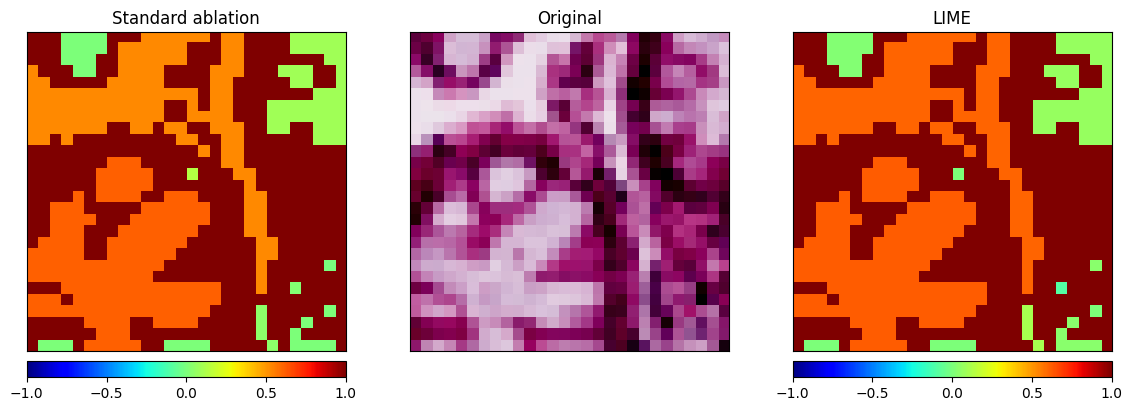

In [33]:
# Create figure with 5 subplots
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

methods = ['heat_map', 'original_image', 'heat_map']
signs = ["all", "all", "all"]

for i, (method, sign) in enumerate(zip(methods, signs)):

    if i == 2: # For final image use the pixel data, not segments

        viz.visualize_image_attr(
            lime_data,
            plot_image,
            method=method,
            sign=sign,
            cmap=plt.cm.jet,
            plt_fig_axis=(fig, ax[i]),
            use_pyplot=False,
            show_colorbar=True
        )

    else:

        viz.visualize_image_attr(
            attribution_map,
            plot_image,
            method=method,
            sign=sign,
            cmap=plt.cm.jet,
            plt_fig_axis=(fig, ax[i]),
            use_pyplot=False,
            show_colorbar=True
        )

ax[0].set_title("Standard ablation")
ax[1].set_title("Original")
ax[2].set_title("LIME")
plt.show()

As can be seen the two methods have very similar results, which is to be expected given the underlying properties of the two methods. Both standard **feature ablation** and **LIME** can be used successfully to explain a models predictions, it may just be a matter of preference or computing resources which determines which method to use.

PRACTICE EXERCISE

Download this notebook. Using only **incorrect** predictions of a singular class, create a plot of 5 images and their feature importance maps to better understand why the model made these predictions.

Use all **three** methods we have covered in this lesson.

## Summary

We have walked through the process of gaining information about what features in an image are most important for a model to make its predictions. However, it must be noted that scores and importances can be misleading. In these steps we have only been **removing** a few pixels or a singular segment at a time. It could be that a combination of segments or non-localised pixels are the most responsible for a prediction, and we have missed it.

As always, it is best to use feature importance as a guide alongside expert domain knowledge of the dataset, to guide investigations towards likely features.